In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import cf_xarray as cfxr

from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy import stats
from datetime import timedelta

import seaborn as sns
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

## Notes:

GFDL: 1pct and esm pi-control start from year 0001

UKESM1: 1pct starts in 1850 and pi-control starts in 1960, move 1pct to start in 1960

MIROC: both start from 1850

NORESM2: 1pct from 0001 pi-control from 1600-- move 1pct to 1600

ACCESS: 1pct and pi-control from 0101

CANESM5_r1p2: 1pct 1850, pi-control 5550, move 1pct to 5550


In [3]:
model_run_pulse_dict = utils.model_run_pulse_dict
model_run_1pct_dict = utils.model_run_1pct_dict
model_run_control_dict = utils.model_run_picontrol_dict
model_run_cdr_pulse_dict = utils.model_run_cdr_pulse_dict


In [4]:
model_color = utils.model_color
type_color = utils.type_color

In [5]:
#define our output grid size

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)

In [6]:
A = utils.find_area(ds_out)

In [7]:
tas_co2_1pct = {}
tas_co2_pictrl = {}

for m in model_run_1pct_dict.keys():
    print(m)
    print('tas')
    tas_co2_1pct[m] = xr.open_mfdataset(f'cmip6_data/tas_Amon_{model_run_1pct_dict[m]}',  use_cftime=True) #kg/m2/s
    lat_corners = cfxr.bounds_to_vertices(tas_co2_1pct[m].isel(time = 0)['lat_bnds'], "bnds", order=None)
    lon_corners = cfxr.bounds_to_vertices(tas_co2_1pct[m].isel(time = 0)['lon_bnds'], "bnds", order=None)
    tas_co2_1pct[m] = tas_co2_1pct[m].assign(lon_b=lon_corners, lat_b=lat_corners)
    tas_co2_1pct[m] = utils._regrid_ds(tas_co2_1pct[m], ds_out)
for m in model_run_control_dict.keys():
    print(m)
    print('tas')
    tas_co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/tas_Amon_{model_run_control_dict[m]}',  use_cftime=True) #kg/m2/s
    lat_corners = cfxr.bounds_to_vertices(tas_co2_pictrl[m].isel(time = 0)['lat_bnds'], "bnds", order=None)
    lon_corners = cfxr.bounds_to_vertices(tas_co2_pictrl[m].isel(time = 0)['lon_bnds'], "bnds", order=None)
    tas_co2_pictrl[m] = tas_co2_pictrl[m].assign(lon_b=lon_corners, lat_b=lat_corners)
    tas_co2_pictrl[m] = utils._regrid_ds(tas_co2_pictrl[m], ds_out)

## fix the times so that they line up according to the notes above
m = 'NORESM2'
tas_co2_pictrl[m]['time'] = tas_co2_pictrl[m]['time'] -timedelta(365*1599)

m = 'UKESM1_r1'
tas_co2_pictrl[m]['time'] = tas_co2_pictrl[m]['time'] - timedelta(360*110)

m = 'CANESM5_r1p2'
tas_co2_pictrl[m]['time'] = tas_co2_pictrl[m]['time']- timedelta(365*3700)

m = 'CANESM5_r1p1'
tas_co2_pictrl[m]['time'] = tas_co2_pictrl[m]['time']- timedelta(365*3351)


UKESM1_r1
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


UKESM1_r2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


UKESM1_r3
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


UKESM1_r4
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


MIROC
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


NORESM2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


ACCESS
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


GFDL
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r1p2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r2p2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r3p2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r1p1
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r2p1
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r3p1
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


UKESM1_r1
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


MIROC
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


NORESM2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


ACCESS
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


GFDL
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r1p2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r1p1
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [8]:
dif = {}
for m1 in model_run_1pct_dict.keys():
    print(m1)
    if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
        m2 = 'UKESM1_r1'
    elif m1 == 'CANESM5_r1p1' or m1 == 'CANESM5_r2p1' or m1 == 'CANESM5_r3p1':
         m2 = 'CANESM5_r1p1'
    elif m1 == 'CANESM5_r1p2' or m1 == 'CANESM5_r2p2' or m1 == 'CANESM5_r3p2':
         m2 = 'CANESM5_r1p2'
    else:
        m2 = m1
    print(m1, m2)
    
    dif[m1] = tas_co2_1pct[m1] - tas_co2_pictrl[m2]
    times = pd.date_range('2000', periods=len(dif[m1]['time']), freq='MS')
    weights = times.shift(1, 'MS') - times
    weights = xr.DataArray(weights, [('time', dif[m1]['time'].values)]).astype('float')
    dif[m1] =  (dif[m1] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')

    #dif[m1] = dif[m1].groupby('time.year').mean()
    dif[m1]['year'] = range(len(dif[m1]['year']))

UKESM1_r1
UKESM1_r1 UKESM1_r1
UKESM1_r2
UKESM1_r2 UKESM1_r1
UKESM1_r3
UKESM1_r3 UKESM1_r1
UKESM1_r4
UKESM1_r4 UKESM1_r1
MIROC
MIROC MIROC
NORESM2
NORESM2 NORESM2
ACCESS
ACCESS ACCESS
GFDL
GFDL GFDL
CANESM5_r1p2
CANESM5_r1p2 CANESM5_r1p2
CANESM5_r2p2
CANESM5_r2p2 CANESM5_r1p2
CANESM5_r3p2
CANESM5_r3p2 CANESM5_r1p2
CANESM5_r1p1
CANESM5_r1p1 CANESM5_r1p1
CANESM5_r2p1
CANESM5_r2p1 CANESM5_r1p1
CANESM5_r3p1
CANESM5_r3p1 CANESM5_r1p1


In [9]:
for m in dif.keys():
    dif[m] = dif[m].drop('height')

In [10]:
ds_dif = xr.concat([dif[m] for m in dif.keys()], pd.Index([m for m in dif.keys()], name='model'), coords='minimal')


In [11]:
ds_dif = ds_dif.rename({'year':'s'})

## Import G

In [12]:
G_ds = xr.open_dataset('Outputs/G_ds.nc4')['__xarray_dataarray_variable__']
G_mean_ds = xr.open_dataset('Outputs/G_mean_ds.nc4')['__xarray_dataarray_variable__']

G_CDR_ds = xr.open_dataset('Outputs/G_cdr_ds.nc4')['__xarray_dataarray_variable__']
G_CDR_mean_ds = xr.open_dataset('Outputs/G_cdr_mean_ds.nc4')['__xarray_dataarray_variable__']

In [13]:
G_ds = xr.concat([G_ds, -G_CDR_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))
G_mean_ds = xr.concat([G_mean_ds, -G_CDR_mean_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))

In [14]:
G_ds.name = 'G[tas]'
G_mean_ds.name = 'G[tas]'

In [15]:
G_ds = G_ds.rename({'year':'s'})
G_mean_ds = G_mean_ds.rename({'year':'s'})

## Emissions profile

In [16]:
emis_profile = xr.open_dataset(f'Outputs/1pct_emis_profile_full.nc4')
emis_profile = emis_profile.rename({'__xarray_dataarray_variable__':'emis'})

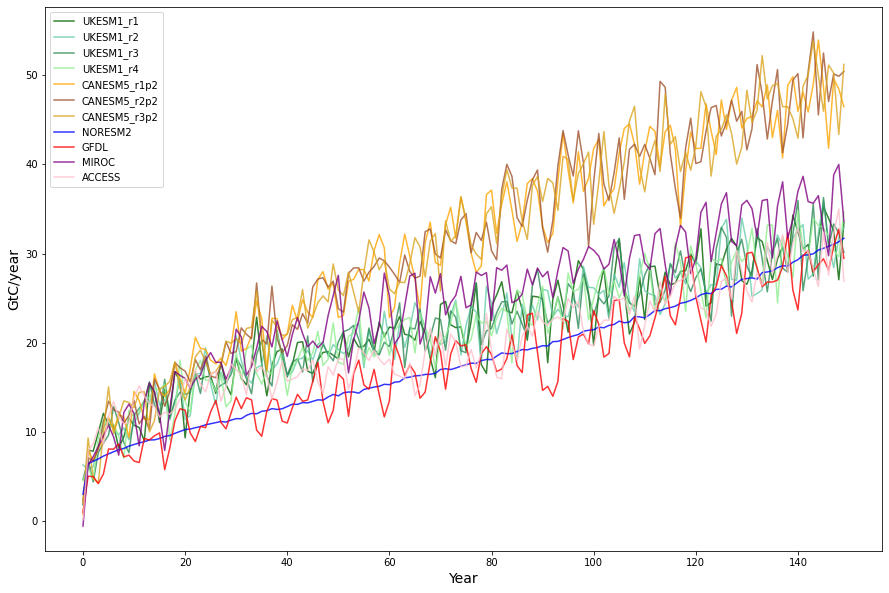

In [17]:
fig, ax = plt.subplots(figsize = [15,10])
for m in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'CANESM5_r1p2', 'CANESM5_r2p2', 'CANESM5_r3p2', 'NORESM2', 'GFDL', 'MIROC', 'ACCESS']:
    plt.plot(emis_profile.sel(model = m)['emis'], alpha = .8, label = f'{m}', color = model_color[m])
#plt.plot(emis_profile.mean(dim = 'model')['emis'], color = 'k', label = f'Model Mean')
plt.legend()
plt.xlabel('Year', fontsize = 14)
plt.ylabel('GtC/year', fontsize = 14)
plt.savefig('figures/1pct_increase/emis_profiles.png', bbox_inches = 'tight', dpi = 350)

## Define our Model Weights

In [17]:
#define our weights for models (grouping UKESM and CANESM realizations)
model_weights = {'UKESM1_r1': 0.25, 'UKESM1_r2': 0.25, 'UKESM1_r3': 0.25, 'UKESM1_r4': 0.25, 'NORESM2': 1, 'GFDL': 1,
       'MIROC': 1, 'ACCESS': 1,  'CANESM5_r2p2':1/3, 'CANESM5_r1p2':1/3, 'CANESM5_r3p2':1/3}
model_weights = xr.DataArray(
    data=list(model_weights.values()),
    dims=["model"],
    coords=dict(
        model=(["model"], list(model_weights.keys()))
    ),
    attrs=dict(
        description="weights for models"
    ),
)

In [18]:
#define our weights for models (grouping UKESM and CANESM realizations)
onepct_model_weights = {'UKESM1_r1': 0.25, 'UKESM1_r2': 0.25, 'UKESM1_r3': 0.25, 'UKESM1_r4': 0.25, 'NORESM2': 1, 'GFDL': 1,
       'MIROC': 1, 'CANESM5_r3p1':1/6, 'ACCESS':1, 'CANESM5_r2p2':1/6, 'CANESM5_r2p1':1/6,
       'CANESM5_r1p2':1/6, 'CANESM5_r1p1':1/6, 'CANESM5_r3p2':1/6}
onepct_model_weights = xr.DataArray(
    data=list(onepct_model_weights.values()),
    dims=["model"],
    coords=dict(
        model=(["model"], list(onepct_model_weights.keys()))
    ),
    attrs=dict(
        description="weights for models"
    ),
)

## Global Mean Analysis

In [19]:
%%time
GF = G_ds.weighted(A).mean(dim = ['lat','lon'])

conv_1pct_mean = {}
for m1 in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2',
   'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2']:
    conv_1pct_mean[m1] = {}
    for t in ['pulse','cdr']:
        if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
            m2 = 'UKESM1_r1'
        else:
            m2 = m1
        conv_1pct_mean[m1][t] = signal.convolve( np.array(GF.sel(model = m2, pulse_type = t).dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis']),'full')
        conv_1pct_mean[m1][t] = utils.np_to_xr_mean(conv_1pct_mean[m1][t], GF.sel(model = m2, pulse_type = t), emis_profile.sel(model = m1))


CPU times: user 2 s, sys: 7.16 s, total: 9.16 s
Wall time: 9.4 s


In [20]:
%%time
GF = G_ds.weighted(A).mean(dim = ['lat','lon'])

conv_1pct_mean_rolling = {}
for m1 in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2',
   'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2']:
    conv_1pct_mean_rolling[m1] = {}
    for t in ['pulse','cdr']:
        if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
            m2 = 'UKESM1_r1'
        else:
            m2 = m1
        conv_1pct_mean_rolling[m1][t] = signal.convolve( np.array(GF.sel(model = m2, pulse_type = t).rolling(s = 10, center = True).mean('year').dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis']),'full')
        conv_1pct_mean_rolling[m1][t] = utils.np_to_xr_mean(conv_1pct_mean_rolling[m1][t], GF.sel(model = m2, pulse_type = t).rolling(s = 10, center = True).mean('year'), emis_profile.sel(model = m1))


CPU times: user 2.21 s, sys: 1.76 s, total: 3.97 s
Wall time: 3.99 s


In [21]:
#convert to dataset

conv_1pct_dict = {}
for m in conv_1pct_mean.keys():
    conv_1pct_dict[m] = xr.concat([conv_1pct_mean[m][t] for t in conv_1pct_mean[m].keys()], pd.Index([t for t in conv_1pct_mean[m].keys()], name='pulse_type'), coords='minimal')
conv_1pct_mean_ds = xr.concat([conv_1pct_dict[m] for m in conv_1pct_dict.keys()], pd.Index([m for m in conv_1pct_dict.keys()], name='model'), coords='minimal')

#convert to dataset

conv_1pct_rolling_dict = {}
for m in conv_1pct_mean_rolling.keys():
    conv_1pct_rolling_dict[m] = xr.concat([conv_1pct_mean_rolling[m][t] for t in conv_1pct_mean_rolling[m].keys()], pd.Index([t for t in conv_1pct_mean_rolling[m].keys()], name='pulse_type'), coords='minimal')
conv_1pct_mean_rolling_ds = xr.concat([conv_1pct_rolling_dict[m] for m in conv_1pct_rolling_dict.keys()], pd.Index([m for m in conv_1pct_rolling_dict.keys()], name='model'), coords='minimal')


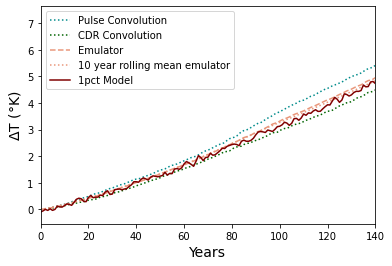

In [60]:
names = {'pulse':'Pulse Convolution', 'cdr':'CDR Convolution'}
for t in ['pulse','cdr']:
    plt.plot(conv_1pct_mean_ds.weighted(model_weights).mean(dim = 'model').sel(pulse_type = t), label = names[t], color = type_color[t], linestyle = ':')
plt.plot(conv_1pct_mean_ds.weighted(model_weights).mean(dim = ['model', 'pulse_type']), label = f'Emulator', color = type_color['all'], linestyle = '--')
#plt.plot(conv_1pct_mutlimod_mean, label = f'Emulator 2', color = 'orange', linestyle = ':')
plt.plot(conv_1pct_mean_rolling_ds.weighted(model_weights).mean(dim = ['model', 'pulse_type']), label = f'10 year rolling mean emulator', color = type_color['all'], linestyle = ':')


plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(model_weights).mean(dim = 'model').weighted(A).mean(dim = ['lat','lon'])['tas'], 
         label = '1pct Model', color = type_color['model'])
plt.legend()
plt.xlim(0,140)
plt.xlabel('Years', fontsize = 14)
plt.ylabel('$\Delta$T ($\degree$C)', fontsize = 14)
plt.savefig('figures/1pct_increase/model_mean_convolution_vs_1pct.png', bbox_inches = 'tight', dpi = 350)


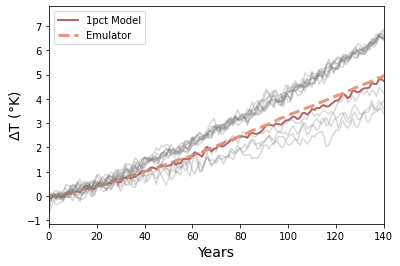

In [22]:
names = {'pulse':'Pulse Convolution', 'cdr':'CDR Convolution'}
plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(model_weights).mean(dim = 'model').weighted(A).mean(dim = ['lat','lon'])['tas'], 
         label = '1pct Model', color = type_color['model'], linewidth = 2, alpha = .6)
plt.plot(conv_1pct_mean_ds.weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type'), label = f'Emulator', color = type_color['all'], linestyle = '--', linewidth = 3)

for m in ds_dif.model:
    plt.plot(ds_dif.weighted(A).mean(dim = ['lat','lon'])['tas'].sel(model = m), 
              alpha = .3, color = 'grey')

plt.legend()
plt.xlim(0,140)
plt.xlabel('Years', fontsize = 14)
plt.ylabel('$\Delta$T ($\degree$C)', fontsize = 14)
plt.savefig('figures/1pct_increase/model_mean_convolution_vs_1pct_spread.png', bbox_inches = 'tight', dpi = 350)


In [ ]:
fig = plt.figure(figsize = [20,15])
plt.suptitle('Annual Mean', fontsize = 16, x = 0.5, y = 0.99)
for idx, m in enumerate(['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2', 'GFDL', 'MIROC', 'ACCESS', 'CANESM5_r1p2', 'CANESM5_r2p2', 'CANESM5_r3p2']):
    ax = plt.subplot(3, 4, idx + 1)
    ax.plot(conv_1pct_mean_ds.sel(model = m, pulse_type = 'cdr'), label = f'{m} cdr convolution', color = model_color[m], linestyle = '--')
    ax.plot(conv_1pct_mean_ds.sel(model = m, pulse_type = 'pulse'), label = f'{m} pulse convolution', color = model_color[m], linestyle = ':')
    ax.plot(conv_1pct_mean_ds.sel(model = m).mean(dim = 'pulse_type'), label = f'{m} convolution', color = model_color[m], linestyle = '-.')
    ax.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon']).sel(model = m)['tas'], label = m,color = model_color[m])

    plt.grid(alpha = 0.4)
    plt.legend()
    plt.xlim(0,140)
    plt.ylim(0,8)
    plt.xlabel('Years', fontsize = 14)
    plt.ylabel('$\Delta$T ($\degree$C)', fontsize = 14)
    plt.tight_layout()
plt.savefig('figures/1pct_increase/1pct_vs_pulses_by_model_mean.png', dpi = 300, bbox_inches = 'tight')

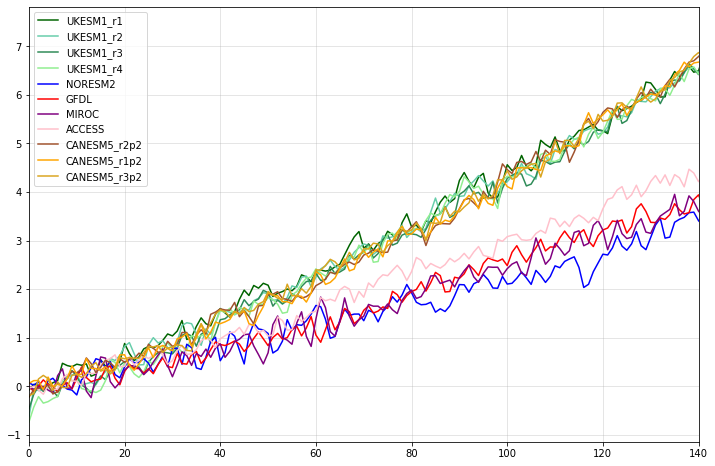

In [41]:
fig, ax = plt.subplots(figsize = (12,8))
for m in model_weights.model.values:
    plt.plot(ds_dif.weighted(A).mean(dim = ['lat','lon'])['tas'].sel(model = m), 
               color = model_color[m], label = m)
plt.grid(alpha = 0.4)
plt.legend()
plt.xlim(0,140)
#plt.ylim(0,7)
plt.savefig('figures/1pct_increase/1pct_all_models.png', bbox_inches = 'tight', dpi = 350)


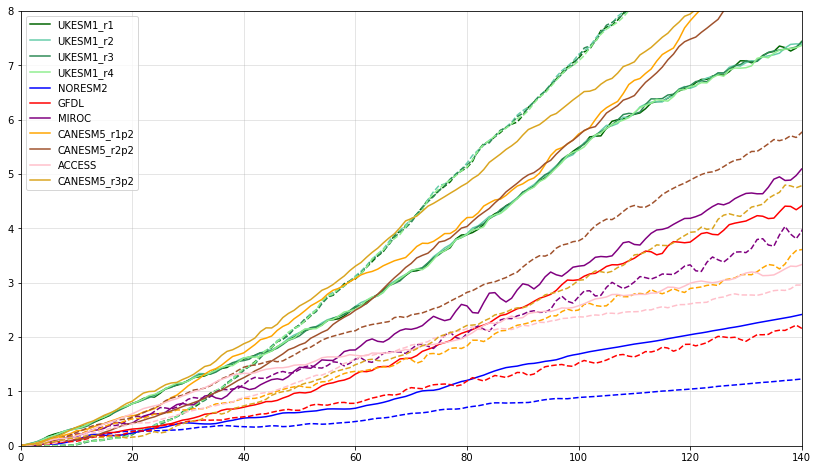

In [21]:
fig, ax = plt.subplots(figsize = [14,8])
for m in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2', 'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2']:
    plt.plot(conv_1pct_mean_ds.sel(model =m, pulse_type = 'pulse'), label = f'{m}', color = model_color[m])
    plt.plot(conv_1pct_mean_ds.sel(model =m, pulse_type = 'cdr'), color = model_color[m], linestyle = '--')
plt.grid(alpha = 0.4)
plt.legend()
plt.xlim(0,140)
plt.ylim(0,8)
plt.savefig('figures/1pct_increase/all_models_convolution.png', bbox_inches = 'tight', dpi = 350)


## TCRE

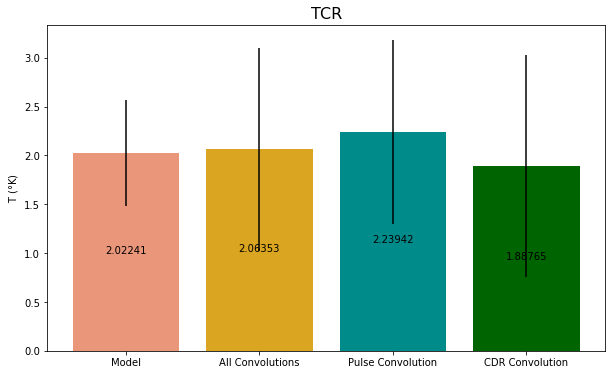

In [215]:
x = ['Model', 'All Convolutions', 'Pulse Convolution', 'CDR Convolution']
y = [ds_dif.sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'].weighted(model_weights).mean(dim = 'model').values,
conv_1pct_mean_ds.sel(s = slice(60,80)).mean(dim = ['s']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').values,
conv_1pct_mean_ds.sel(pulse_type = 'pulse').sel(s = slice(60,80)).mean(dim = ['s']).weighted(model_weights).mean(dim = 'model').values,
conv_1pct_mean_ds.sel(pulse_type = 'cdr').sel(s = slice(60,80)).mean(dim = ['s']).weighted(model_weights).mean(dim = 'model').values]

num_std = 1
yerr = [num_std*ds_dif.sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'].weighted(model_weights).std(dim = 'model').values,
num_std*conv_1pct_mean_ds.sel(s = slice(60,80)).mean(dim = ['s']).weighted(model_weights).std(dim = 'model').mean(dim = 'pulse_type').values,
num_std*conv_1pct_mean_ds.sel(pulse_type = 'pulse').sel(s = slice(60,80)).mean(dim = ['s']).weighted(model_weights).std(dim = 'model').values,
num_std*conv_1pct_mean_ds.sel(pulse_type = 'cdr').sel(s = slice(60,80)).mean(dim = ['s']).weighted(model_weights).std(dim = 'model').values]

fig, ax = plt.subplots(figsize = [10,6])
bars = plt.bar(x, y, color = type_color.values())
plt.bar_label(bars, label_type = 'center', padding = 2)
plt.ylabel('T ($\degree$C)')
for idx in np.arange(0,len(y)):
    idx_convert = {0:'model',1:'pulse',2:'cdr',3:'all'}
    plt.errorbar(x = x[idx], y = y[idx], yerr = yerr[idx], color = 'k')
plt.title("TCR", fontsize = 16)
plt.savefig('figures/1pct_increase/bar_plot_TCR.png', bbox_inches = 'tight', dpi = 300)

In [23]:

def reindex_df(df, weight_col):
    """expand the dataframe to prepare for resampling
    result is 1 row per count per sample"""
    df = df.reindex(df.index.repeat(df[weight_col]))
    df.reset_index(drop=True, inplace=True)
    return(df)


data = {'mean': conv_1pct_mean_ds.sel(pulse_type = 'pulse').sel(s = slice(60,80)).mean(dim = ['s']).values,
        'model': conv_1pct_mean_ds.model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 12, 4, 4, 4]}
df_pulse = pd.DataFrame(data)
df_pulse = reindex_df(df_pulse, weight_col = 'count')


data = {'mean': conv_1pct_mean_rolling_ds.mean(dim = ['pulse_type']).sel(s = slice(60,80)).mean(dim = ['s']).values,
        'model': conv_1pct_mean_rolling_ds.model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 12, 4, 4, 4]}
df_emulator_roll = pd.DataFrame(data)
df_emulator_roll = reindex_df(df_emulator_roll, weight_col = 'count')

data = {'mean': conv_1pct_mean_ds.mean(dim = ['pulse_type']).sel(s = slice(60,80)).mean(dim = ['s']).values,
        'model': conv_1pct_mean_ds.model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 12, 4, 4, 4]}
df_emulator = pd.DataFrame(data)
df_emulator = reindex_df(df_emulator, weight_col = 'count')

data = {'mean': conv_1pct_mean_ds.sel(pulse_type = 'cdr').sel(s = slice(60,80)).mean(dim = ['s']).values,
        'model': conv_1pct_mean_ds.model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 12, 4, 4, 4]}
df_cdr = pd.DataFrame(data)
df_cdr = reindex_df(df_cdr, weight_col = 'count')


data = {'mean': ds_dif.where(ds_dif['model'].isin(model_weights.model.values), drop = True).sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'].values,
        'model': ds_dif.where(ds_dif['model'].isin(model_weights.model.values), drop = True).model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 12, 4, 4, 4]}

df_model = pd.DataFrame(data)
df_model = reindex_df(df_model, weight_col = 'count')


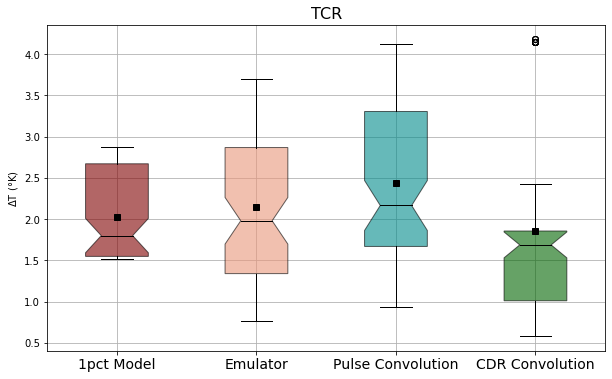

In [24]:
x = ['1pct Model', 'Emulator', 'Pulse Convolution', 'CDR Convolution']
y = [df_model['mean'],
    (df_cdr + df_pulse)['mean']/2,
     df_pulse['mean'],
    df_cdr['mean']]
fig, ax = plt.subplots(figsize = [10,6])
box = plt.boxplot(y, showmeans= True, notch = True, patch_artist=True, meanprops={"marker":"s","markerfacecolor":"black", "markeredgecolor":"black"})
for patch, color in zip(box['boxes'], type_color.values()):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
for median in box['medians']:
    median.set_color('black')
plt.grid()
plt.ylabel('$\Delta$T ($\degree$C)')
ax.set_xticklabels(x, fontsize = 14)
plt.title("TCR", fontsize = 16)
plt.savefig('figures/1pct_increase/TCR_boxplots.png', bbox_inches = 'tight', dpi = 300)

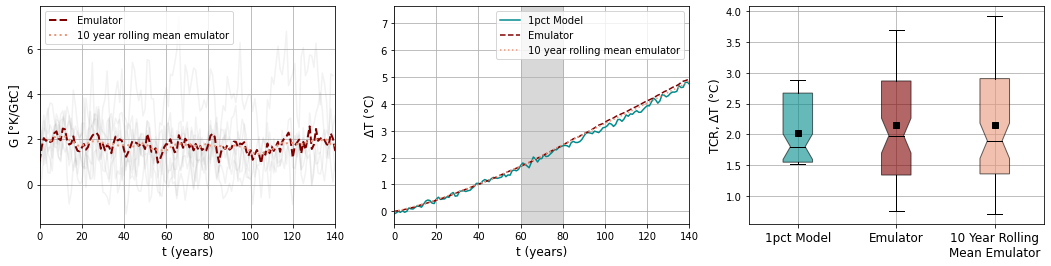

In [30]:
## supplemental figure with rolling mean
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = [18,4])
GtC_per_TtC = 1e3
####Plot the GF
for m in G_ds.model:
    (G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).mean(dim = 'pulse_type')*GtC_per_TtC).plot(ax = ax1, color = 'grey', alpha = .1)
ax1.set_title('Annual Mean', fontsize = 16)
ax1.set_xlim(G_ds.s.min(), G_ds.s[140].values)

(G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = ['model', 'pulse_type'])*GtC_per_TtC).plot(ax = ax1, label = 'Emulator', color = type_color['emulator'], linewidth = 2, linestyle = '--')
(G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = ['model', 'pulse_type'])*GtC_per_TtC).rolling(s = 10, center = True).mean('s').plot(ax = ax1, label = '10 year rolling mean emulator', color = type_color['rolling_emulator'], linewidth = 2, linestyle = ':')
ax1.set_ylabel('G [$\degree$K/GtC]', fontsize = 12)
ax1.set_xlabel('t (years)', fontsize = 12)
ax1.grid()
ax1.legend()

###Plot the 1pct model runs
ax2.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(model_weights).mean(dim = 'model').weighted(A).mean(dim = ['lat','lon'])['tas'], 
         label = '1pct Model', color = type_color['model'])
ax2.plot(conv_1pct_mean_ds.weighted(model_weights).mean(dim = ['model', 'pulse_type']), label = f'Emulator', color = type_color['emulator'], linestyle = '--')
ax2.plot(conv_1pct_mean_rolling_ds.weighted(model_weights).mean(dim = ['model', 'pulse_type']), label = f'10 year rolling mean emulator', color = type_color['rolling_emulator'], linestyle = ':')
ax2.grid()

ax2.axvspan(60, 80, alpha=0.3, color='grey')
ax2.legend()
ax2.set_xlim(0,140)
ax2.set_xlabel('t (years)', fontsize = 12)
ax2.set_ylabel('$\Delta$T ($\degree$C)', fontsize = 12)


####Plot the TCRE comparison
x = ['1pct Model', 'Emulator', '10 Year Rolling\nMean Emulator']
y = [df_model['mean'],
    df_emulator['mean'],
    df_emulator_roll['mean']]
box = ax3.boxplot(y, showmeans= True, notch = True, patch_artist=True, meanprops={"marker":"s","markerfacecolor":"black", "markeredgecolor":"black"})
for patch, color in zip(box['boxes'], type_color.values()):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
for median in box['medians']:
    median.set_color('black')
ax3.grid()
ax3.set_ylabel('TCR, $\Delta$T ($\degree$C)', fontsize = 12)
ax3.set_xticklabels(x, fontsize = 12)
plt.savefig('figures/paper/supp_figure_GF_1pct_TCR.png', bbox_inches = 'tight', dpi = 300)

## Model spread for G

In [234]:
x = list(G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = 'pulse_type').model.values)
x.append('1pct Models')
y = list(G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = 'pulse_type').dropna(dim = 's').values)
model_deltaT_gtc = (ds_dif.weighted(A).mean(dim = ['s', 'lon','lat'])['tas']/emis_profile.cumsum(dim = 'year')['emis']).sel(year = slice(60,80)).values
y.append(model_deltaT_gtc.flatten())


In [235]:
color_mod_vals = ['darkgreen', 'blue', 'red', 'purple', 'pink', 'orange', 'sienna', 'goldenrod', 'maroon']

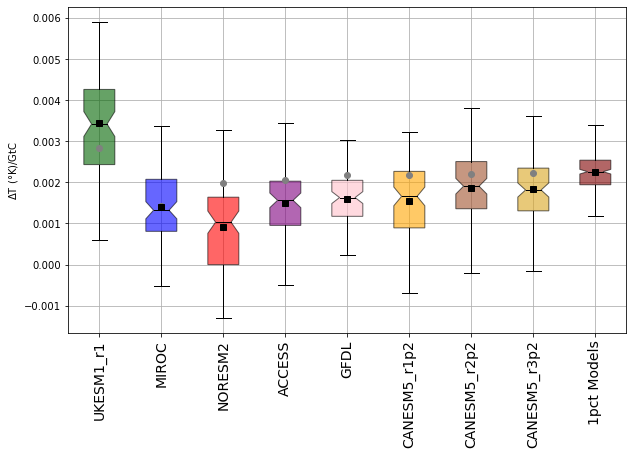

In [237]:
fig, ax = plt.subplots(figsize = [10,6])
box = plt.boxplot(y, showmeans= True, notch = True, patch_artist=True, positions = np.arange(0,len(x)), 
                  showfliers = False, meanprops={"marker":"s","markerfacecolor":"black", "markeredgecolor":"black"})
for patch, color in zip(box['boxes'],  color_mod_vals):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
for median in box['medians']:
    median.set_color('black')
plt.plot(ds_dif.where(ds_dif['model'].isin(x), drop = True).model, 
         (ds_dif.where(ds_dif['model'].isin(x), drop = True).weighted(A).mean(dim = ['s', 'lon','lat'])['tas']/emis_profile.cumsum(dim = 'year')['emis']).sel(year = slice(60,80)).mean(dim = 'year'), 'o', color = 'grey')


plt.grid()
plt.ylabel('$\Delta$T ($\degree$C)/GtC')

ax.set_xticklabels(x, fontsize = 14, rotation = 90)
plt.savefig('figures/1pct_increase/model_spread_boxplots.png', bbox_inches = 'tight', dpi = 300)

## Spatial Analysis

In [24]:
%%time

GF = G_ds

conv_1pct = {}

for m1 in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2',
   'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2',]:
    conv_1pct[m1] = {}
    print(m1)
    for t in ['pulse','cdr']:
        if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
            m2 = 'UKESM1_r1'
        else:
            m2 = m1
        print(m1, m2)
        conv_1pct[m1][t] = signal.convolve(np.array(GF.sel(model = m2, pulse_type = t).dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis'])[..., None, None],'full')
        conv_1pct[m1][t] = utils.np_to_xr(conv_1pct[m1][t], GF.sel(model = m2, pulse_type = t), emis_profile.sel(model = m1))


UKESM1_r1
UKESM1_r1 UKESM1_r1
UKESM1_r1 UKESM1_r1
UKESM1_r2
UKESM1_r2 UKESM1_r1
UKESM1_r2 UKESM1_r1
UKESM1_r3
UKESM1_r3 UKESM1_r1
UKESM1_r3 UKESM1_r1
UKESM1_r4
UKESM1_r4 UKESM1_r1
UKESM1_r4 UKESM1_r1
NORESM2
NORESM2 NORESM2
NORESM2 NORESM2
GFDL
GFDL GFDL
GFDL GFDL
MIROC
MIROC MIROC
MIROC MIROC
CANESM5_r1p2
CANESM5_r1p2 CANESM5_r1p2
CANESM5_r1p2 CANESM5_r1p2
CANESM5_r2p2
CANESM5_r2p2 CANESM5_r2p2
CANESM5_r2p2 CANESM5_r2p2
ACCESS
ACCESS ACCESS
ACCESS ACCESS
CANESM5_r3p2
CANESM5_r3p2 CANESM5_r3p2
CANESM5_r3p2 CANESM5_r3p2
CPU times: user 10.8 s, sys: 13.4 s, total: 24.1 s
Wall time: 24.2 s


In [25]:
#convert to dataset

conv_1pct_dict = {}
for m in conv_1pct.keys():
    conv_1pct_dict[m] = xr.concat([conv_1pct[m][t] for t in conv_1pct[m].keys()], pd.Index([t for t in conv_1pct[m].keys()], name='pulse_type'), coords='minimal')
    conv_1pct_ds = xr.concat([conv_1pct_dict[m] for m in conv_1pct_dict.keys()], pd.Index([m for m in conv_1pct_dict.keys()], name='model'), coords='minimal')


In [ ]:
## plot the trend over a given time period for all models
for t in [10,70]:
    for p in ['cdr','pulse']:
        fig, axes = plt.subplots(len(conv_1pct_ds.model), 3,figsize = [20,50], sharex = True, sharey = True, subplot_kw = {'projection':ccrs.PlateCarree()})
        vmin = -4
        vmax = 4
        for idx_m, m in enumerate(conv_1pct_ds.model.values):
            conv_1pct_ds.sel(model = m, pulse_type = p, s = slice(t-10, t+10)).mean(dim = 's').plot(ax = axes[idx_m, 0], vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
            axes[idx_m, 0].set_title(f'Convolution, {p}', fontsize = 14)
            axes[idx_m, 0].text(-0.08, 0.5, m, horizontalalignment='center', verticalalignment='center', rotation='vertical', transform=axes[idx_m, 0].transAxes, fontsize = 14)
            axes[idx_m, 0].coastlines()


            ds_dif.sel(model = m, s = slice(t-10, t+10)).mean(dim = 's')['tas'].plot(ax = axes[idx_m, 1], vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
            axes[idx_m, 1].set_title('1pct data', fontsize = 14)
            axes[idx_m, 1].coastlines()


            (conv_1pct_ds.sel(model = m, pulse_type = p) - ds_dif['tas'].sel(model = 'GFDL')).sel(s = slice(t-10, t+10)).mean(dim = 's').plot(ax = axes[idx_m, 2], vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
            axes[idx_m, 2].set_title('Difference', fontsize = 14)
            axes[idx_m, 2].coastlines()


            plt.suptitle(f'Annual trend to year {t}', fontsize = 16, x = .5, y = .99)
        plt.savefig(f'figures/1pct_increase/annual_trends_{p}_all_{t}.png', bbox_inches = 'tight', dpi = 300)
        plt.tight_layout()
        plt.close();


KeyboardInterrupt: 

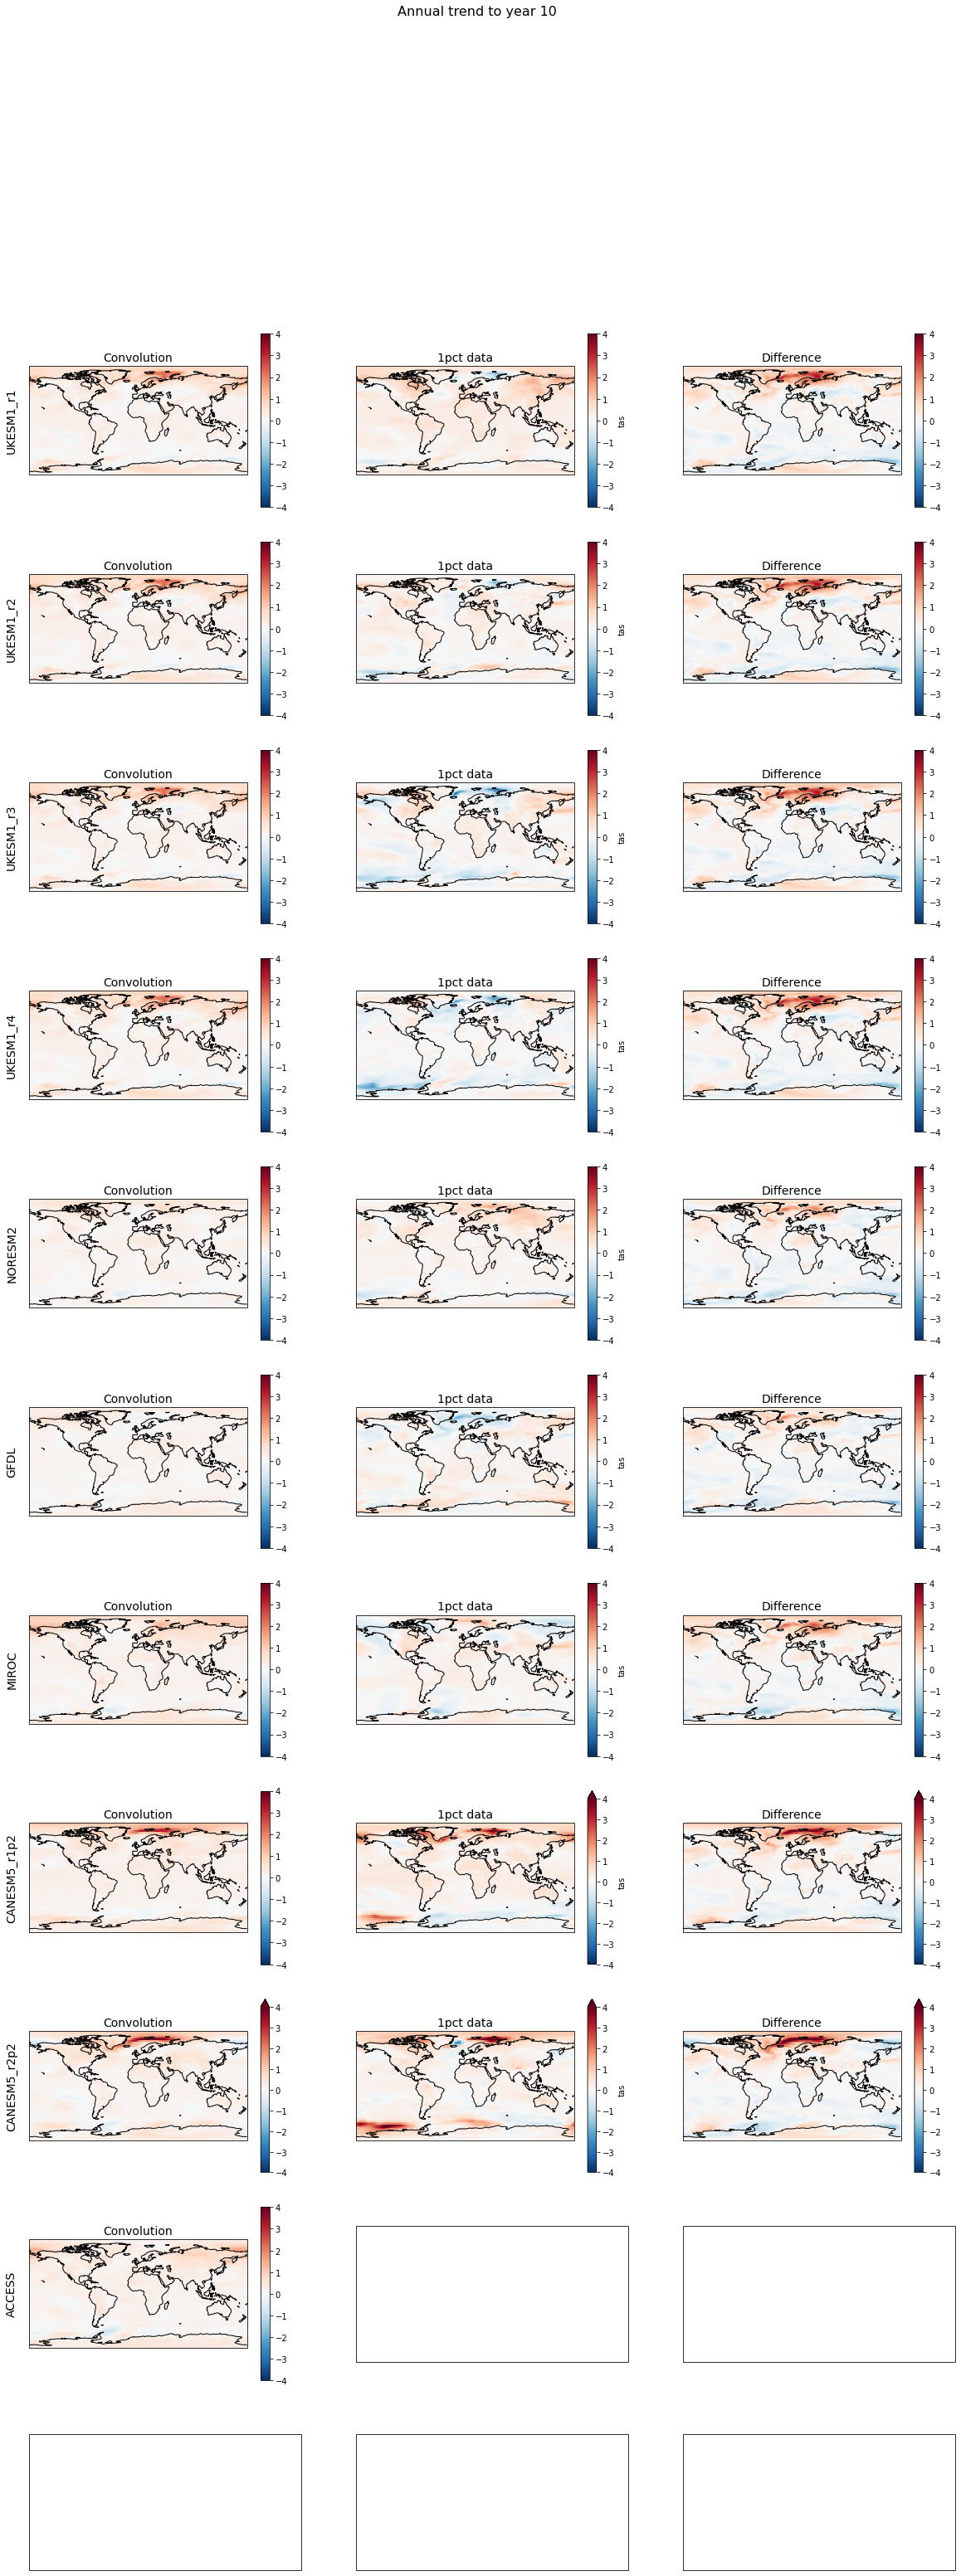

In [26]:
## plot the trend over a given time period for all models, mean over pulse type
for t in [10,70]:
    fig, axes = plt.subplots(len(conv_1pct_ds.model), 3,figsize = [20,50], sharex = True, sharey = True, subplot_kw = {'projection':ccrs.PlateCarree()})
    vmin = -4
    vmax = 4
    for idx_m, m in enumerate(conv_1pct_ds.model.values):
        conv_1pct_ds.sel(model = m, s = slice(t-10, t+10)).mean(dim = ['s','pulse_type']).plot(ax = axes[idx_m, 0], vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
        axes[idx_m, 0].set_title(f'Convolution', fontsize = 14)
        axes[idx_m, 0].text(-0.08, 0.5, m, horizontalalignment='center', verticalalignment='center', rotation='vertical', transform=axes[idx_m, 0].transAxes, fontsize = 14)
        axes[idx_m, 0].coastlines()


        ds_dif.sel(model = m, s = slice(t-10, t+10)).mean(dim = 's')['tas'].plot(ax = axes[idx_m, 1], vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
        axes[idx_m, 1].set_title('1pct data', fontsize = 14)
        axes[idx_m, 1].coastlines()


        (conv_1pct_ds.sel(model = m) - ds_dif['tas'].sel(model = 'GFDL')).sel(s = slice(t-10, t+10)).mean(dim = ['s','pulse_type']).plot(ax = axes[idx_m, 2], vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
        axes[idx_m, 2].set_title('Difference', fontsize = 14)
        axes[idx_m, 2].coastlines()


        plt.suptitle(f'Annual trend to year {t}', fontsize = 16, x = .5, y = .99)
    #plt.savefig(f'figures/1pct_increase/annual_trends_mean_pulse_type_all_{t}.png', bbox_inches = 'tight', dpi = 300)
    plt.tight_layout()
    plt.close();


In [ ]:
## plot the trend over a given time period for mean of models

for t in [10,70]:
    if t == 10:
        vmin = -1
        vmax = 1
    elif t == 70:
        vmin = -4
        vmax = 4
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5], subplot_kw = {'projection':ccrs.PlateCarree()})

    (conv_1pct_ds.weighted(model_weights).mean(dim = 'model').sel( s = slice(t-10, t+10)).mean(dim = 's')/t).mean(dim = 'pulse_type').plot(ax = ax1, 
                                                                                                                             vmax = vmax, vmin = vmin, cmap = 'RdBu_r', 
                                                                                                    cbar_kwargs = {'label':'$\Delta$T ($\degree$K yr$^-1$)'}, transform = ccrs.PlateCarree())
    ax1.set_title(f'Convolution')
    ax1.coastlines()

    (ds_dif.weighted(model_weights).mean(dim = 'model')['tas'].sel(s = slice(t-10, t+10)).mean(dim = 's')/t).plot(ax = ax2, 
                                                                                                        vmax = vmax, vmin = vmin, cmap = 'RdBu_r', 
                                                                                                    cbar_kwargs = {'label':'$\Delta$T ($\degree$K yr$^-1$)'}, transform = ccrs.PlateCarree())
    ax2.set_title('1pct data')
    ax2.coastlines()

    ((conv_1pct_ds - 
     ds_dif['tas']).weighted(model_weights).mean(dim = 'model').sel(s = slice(t-10, t+10)).mean(dim = 's').mean(dim = 'pulse_type')/t).plot(ax = ax3, 
                                                                                                        vmax = 1, vmin = -1, cmap = 'RdBu_r', 
                                                                                                    cbar_kwargs = {'label':'$\Delta$T ($\degree$K yr$^-1$)'}, transform = ccrs.PlateCarree())
    ax3.set_title('Difference')
    ax3.coastlines()

    plt.suptitle(f'Model mean trend to year {t}', fontsize = 16)

    plt.tight_layout()
    #plt.savefig(f'figures/1pct_increase/annual_trends_mean_{t}.png', bbox_inches = 'tight', dpi = 350)
#plt.close();

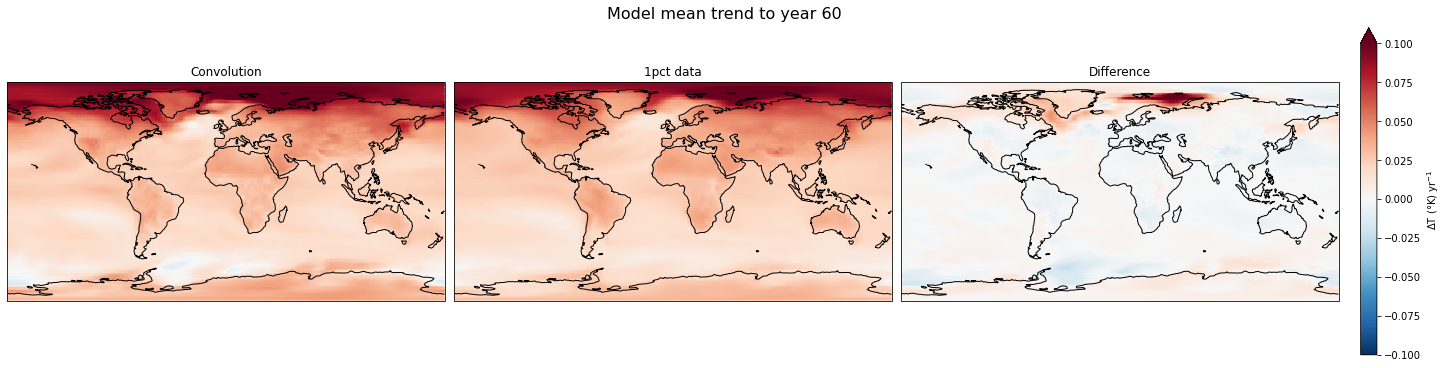

In [162]:
## plot the trend over a given time period for mean of models

for t in [70]:
    vmin = -.1
    vmax = .1

    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

    (conv_1pct_ds.weighted(model_weights).mean(dim = 'model').sel( s = slice(t-10, t+10)).mean(dim = 's')/t).mean(dim = 'pulse_type').plot(ax = ax1, 
                                                                                                                             vmax = vmax, vmin = vmin, cmap = 'RdBu_r', add_colorbar = False)
    ax1.set_title(f'Convolution')
    ax1.coastlines()

    (ds_dif.weighted(model_weights).mean(dim = 'model')['tas'].sel(s = slice(t-10, t+10)).mean(dim = 's')/t).plot(ax = ax2, 
                                                                                                        vmax = vmax, vmin = vmin, cmap = 'RdBu_r', add_colorbar = False)
    ax2.set_title('1pct data')
    ax2.coastlines()

    ((conv_1pct_ds - 
     ds_dif['tas']).weighted(model_weights).mean(dim = 'model').sel(s = slice(t-10, t+10)).mean(dim = 's').mean(dim = 'pulse_type')/t).plot(ax = ax3, 
                                                                                                        vmax = vmax, vmin = vmin, cmap = 'RdBu_r', 
                                                                                                    cbar_kwargs = {'label':'$\Delta$T ($\degree$C) yr$^{-1}$'}, transform = ccrs.PlateCarree())
    ax3.set_title('Difference')
    ax3.coastlines()

    plt.suptitle(f'Model mean trend to year {t}', fontsize = 16)

    #plt.tight_layout()
    plt.savefig(f'figures/1pct_increase/annual_trends_{t}.png', bbox_inches = 'tight', dpi = 350)
#plt.close();

In [ ]:
    ## plot the value at a given year for all models
for t in [10,70]:
    for p in ['cdr','pulse']:
        fig, axes = plt.subplots(len(conv_1pct_ds.model), 3,figsize = [20,50], sharex = True, sharey = True, subplot_kw = {'projection':ccrs.PlateCarree()})
        vmin = -4
        vmax = 4
        for idx_m, m in enumerate(conv_1pct_ds.model.values):
            conv_1pct_ds.sel(model = m, pulse_type = p, s = t).plot(ax = axes[idx_m, 0], 
                                                                          vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
            axes[idx_m, 0].set_title(f'Convolution, {p}', fontsize = 14)
            axes[idx_m, 0].text(-0.08, 0.5, m, horizontalalignment='center', verticalalignment='center', rotation='vertical', transform=axes[idx_m, 0].transAxes, fontsize = 14)
            axes[idx_m, 0].coastlines()

            ds_dif.sel(model = m, s = t)['tas'].plot(ax = axes[idx_m, 1], 
                                                     vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
            axes[idx_m, 1].set_title('1pct data', fontsize = 14)
            axes[idx_m, 1].coastlines()

            (conv_1pct_ds.sel(model = m, pulse_type = p) - ds_dif['tas'].sel(model = 'GFDL')).sel(s = t).plot(ax = axes[idx_m, 2], 
                                                                                                                    vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
            axes[idx_m, 2].set_title('Difference', fontsize = 14)
            axes[idx_m, 2].coastlines()

        plt.suptitle(f'Year {t}', fontsize = 16, x = 0.5, y = 0.99)
        plt.tight_layout()
        plt.savefig(f'figures/1pct_increase/annual_{p}_all_{t}.png', bbox_inches = 'tight', dpi = 350)
        plt.close();

In [ ]:
## plot the value at a given year for all models
for t in [10,70]:
    fig, axes = plt.subplots(len(conv_1pct_ds.model), 3,figsize = [20,50], sharex = True, sharey = True, subplot_kw = {'projection':ccrs.PlateCarree()})
    vmin = -4
    vmax = 4
    for idx_m, m in enumerate(conv_1pct_ds.model.values):
        conv_1pct_ds.sel(model = m, s = t).mean(dim = ['pulse_type']).plot(ax = axes[idx_m, 0], vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
        axes[idx_m, 0].set_title(f'Convolution, {p}', fontsize = 14)
        axes[idx_m, 0].text(-0.08, 0.5, m, horizontalalignment='center', verticalalignment='center', rotation='vertical', transform=axes[idx_m, 0].transAxes, fontsize = 14)
        axes[idx_m, 0].coastlines()

        ds_dif.sel(model = m, s = t)['tas'].plot(ax = axes[idx_m, 1], 
                                                 vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
        axes[idx_m, 1].set_title('1pct data', fontsize = 14)
        axes[idx_m, 1].coastlines()

        (conv_1pct_ds.sel(model = m).mean(dim = ['pulse_type']) - ds_dif['tas'].sel(model = 'GFDL')).sel(s = t).plot(ax = axes[idx_m, 2], 
                                                                                                                vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
        axes[idx_m, 2].set_title('Difference', fontsize = 14)
        axes[idx_m, 2].coastlines()

    plt.suptitle(f'Year {t}', fontsize = 16, x = 0.5, y = 0.99)
    plt.tight_layout()
    plt.savefig(f'figures/1pct_increase/annual_mean_pulse_type_all_{t}.png', bbox_inches = 'tight', dpi = 350)
    plt.close();

KeyboardInterrupt: 

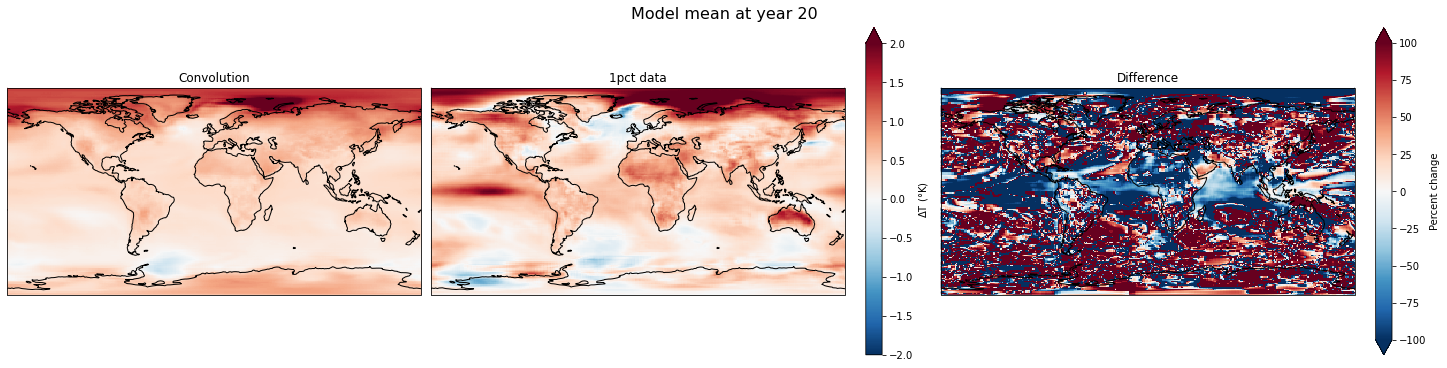

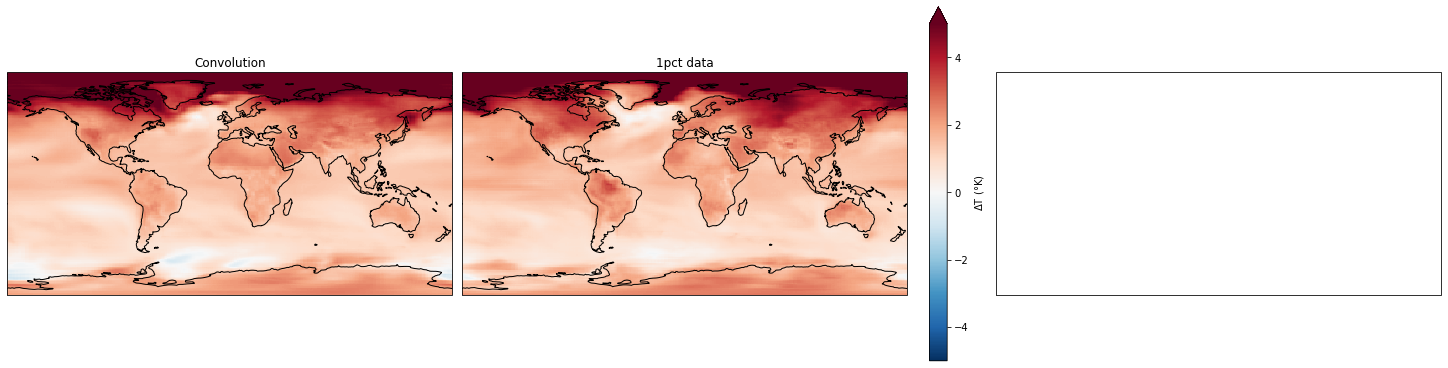

In [22]:
## plot the value at a given year for the mean
vmin = -2
vmax = 2
for t in [10,70]:
    if t == 10:
        vmin = -2
        vmax = 2
    elif t == 70:
        vmin = -5
        vmax = 5
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

    conv_1pct_ds.weighted(model_weights).mean(dim = 'model').sel( s = slice(t-10,t+10)).mean(dim = 'pulse_type').plot(ax = ax1, 
                                                                                                vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree(), add_colorbar = False)
    ax1.set_title(f'Convolution')
    ax1.coastlines()

    ds_dif.weighted(model_weights).mean(dim = 'model')['tas'].sel(s = t).plot(ax = ax2, 
                                                                        vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree(), 
                                                                                                    cbar_kwargs = {'label':'$\Delta$T ($\degree$C)'})
    ax2.set_title('1pct data')
    ax2.coastlines()

    (((conv_1pct_ds - 
     ds_dif['tas'])/conv_1pct_ds)*100).weighted(model_weights).mean(dim = 'model').sel(s = t).mean(dim = 'pulse_type').plot(ax = ax3, 
                                                                            vmax = 100, vmin = -100, cmap = 'RdBu_r', transform = ccrs.PlateCarree(), 
                                                                                                    cbar_kwargs = {'label':'Percent change'})
    ax3.set_title('Difference')
    ax3.coastlines()

    plt.suptitle(f'Model mean at year {t}', fontsize = 16)
    plt.savefig(f'figures/1pct_increase/annual_mean_{t}.png', bbox_inches = 'tight', dpi = 350)
    #plt.close();

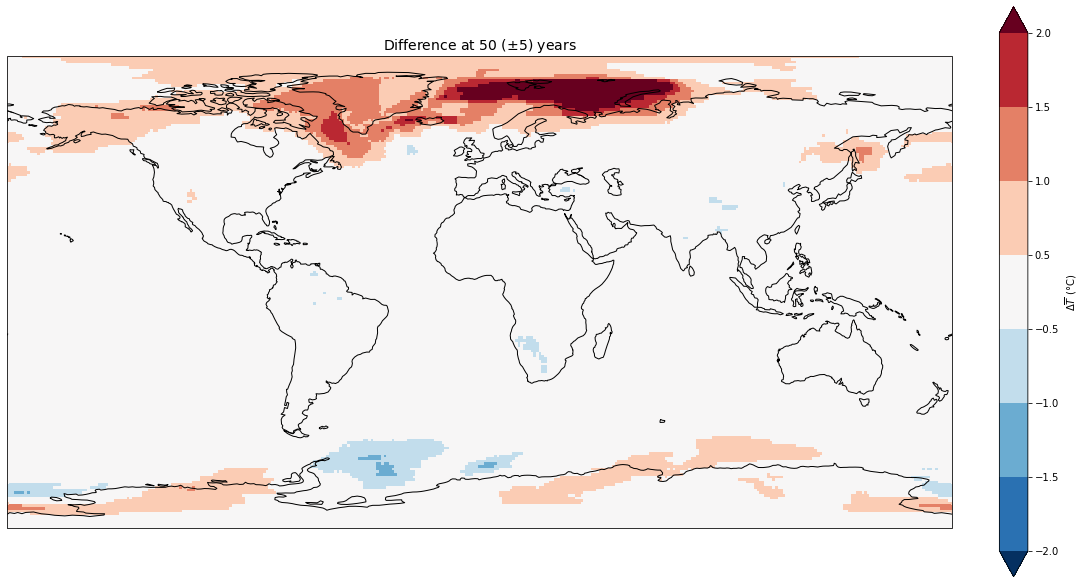

In [29]:
cmap = mpl.cm.RdBu_r
levels = [-2,-1.5,-1,-0.5,0.5,1,1.5,2.0]
vmin = -2
vmax = 2
yr_dif = 5
fig, ax= plt.subplots(figsize = [15,8], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

##########1pct exp##################
##contours of convolution-1pct difference
t = 50

(conv_1pct_ds -  ds_dif['tas']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').plot(ax = ax, 
                                                                                                              cmap = cmap, levels = levels, extend = 'both', 
                                                                                                              add_colorbar = True,     
                                                                                                              transform = ccrs.PlateCarree(),
                                                                                                              cbar_kwargs = {'label':r'$\Delta \overline{T}$ ($\degree$C)'})

ax.set_title(f'Difference at {t} ($\pm 5$) years', fontsize = 14)
ax.coastlines()
plt.savefig('app_fig.png', bbox_inches = 'tight')

## RTCRE 

In [216]:
## to compare to https://www.nature.com/articles/nclimate2913

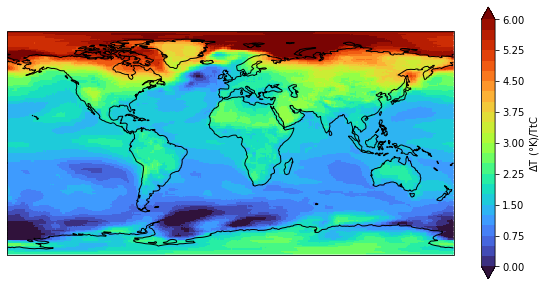

In [75]:
cmap = mpl.cm.turbo
levels = np.arange(0,6.25,0.25)
fig, ax= plt.subplots(figsize = [10,5], subplot_kw = {'projection':ccrs.PlateCarree()})
##contours of convolution-1pct difference
(((conv_1pct_ds.mean(dim = 'pulse_type').sel(s = slice(60, 80)).mean(dim = 's')/
  emis_profile.cumsum(dim = 'year')['emis'].sel(year = slice(60,80)).mean(dim = 'year')).weighted(model_weights).mean(dim = 'model'))*1e3).plot(ax = ax, 
                                                                  cmap = cmap, levels = levels, extend = 'both',
                                                                cbar_kwargs = {'label':'$\Delta$T ($\degree$C)/TtC'},
                                                                transform = ccrs.PlateCarree())
ax.coastlines()
plt.title('')
plt.savefig(f'figures/1pct_increase/difference_tcr_spatial.png', bbox_inches = 'tight', dpi = 300)

In [217]:
rtcre = ((ds_dif.sel(s = slice(60, 80)).mean(dim = 's')/
  emis_profile.cumsum(dim = 'year')['emis'].sel(year = slice(60,80)).mean(dim = 'year')))

In [218]:
rtcre = rtcre.expand_dims(s = ds_dif['s'])

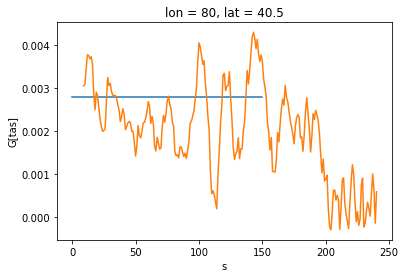

In [231]:
rtcre.where(ds_dif['model'].isin(model_weights.model), drop = True).weighted(model_weights).mean('model').sel(lat = 40, lon =80, method = 'nearest')['tas'].plot()
G_ds.where(ds_dif['model'].isin(model_weights.model), drop = True).weighted(model_weights).mean(['model','pulse_type']).sel(lat = 40, lon =80, method = 'nearest').rolling(s = 10).mean('s').plot()

In [ ]:
rtcre.where(ds_dif['model'].isin(model_weights.model), drop = True).weighted(model_weights).mean('model').sel(lat = -, lon =80, method = 'nearest')['tas'].plot()
G_ds.where(ds_dif['model'].isin(model_weights.model), drop = True).weighted(model_weights).mean(['model','pulse_type']).sel(lat = 40, lon =80, method = 'nearest').plot()

In [148]:
%%time

GF = rtcre['tas']

conv_rtcre = {}

for m1 in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2',
   'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2',]:
    conv_rtcre[m1] = {}
    print(m1)
    for t in ['pulse','cdr']:
        if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
            m2 = 'UKESM1_r1'
        else:
            m2 = m1
        print(m1, m2)
        conv_rtcre[m1][t] = signal.convolve(np.array(GF.sel(model = m2)), np.array(emis_profile.sel(model = m1)['emis'])[..., None, None],'full')
        conv_rtcre[m1][t] = utils.np_to_xr(conv_rtcre[m1][t], G_ds.sel(model = m2), emis_profile.sel(model = m1))


UKESM1_r1
UKESM1_r1 UKESM1_r1
UKESM1_r1 UKESM1_r1
UKESM1_r2
UKESM1_r2 UKESM1_r1
UKESM1_r2 UKESM1_r1
UKESM1_r3
UKESM1_r3 UKESM1_r1
UKESM1_r3 UKESM1_r1
UKESM1_r4
UKESM1_r4 UKESM1_r1
UKESM1_r4 UKESM1_r1
NORESM2
NORESM2 NORESM2
NORESM2 NORESM2
GFDL
GFDL GFDL
GFDL GFDL
MIROC
MIROC MIROC
MIROC MIROC
CANESM5_r1p2
CANESM5_r1p2 CANESM5_r1p2
CANESM5_r1p2 CANESM5_r1p2
CANESM5_r2p2
CANESM5_r2p2 CANESM5_r2p2
CANESM5_r2p2 CANESM5_r2p2
ACCESS
ACCESS ACCESS
ACCESS ACCESS
CANESM5_r3p2
CANESM5_r3p2 CANESM5_r3p2
CANESM5_r3p2 CANESM5_r3p2
CPU times: user 1min 36s, sys: 57.1 s, total: 2min 34s
Wall time: 1min 52s


In [149]:
#convert to dataset

conv_rtcre_dict = {}
for m in conv_rtcre.keys():
    conv_rtcre_dict[m] = xr.concat([conv_rtcre[m][t] for t in conv_rtcre[m].keys()], pd.Index([t for t in conv_rtcre[m].keys()], name='pulse_type'), coords='minimal')
    conv_rtcre_ds = xr.concat([conv_rtcre_dict[m] for m in conv_rtcre_dict.keys()], pd.Index([m for m in conv_rtcre_dict.keys()], name='model'), coords='minimal')


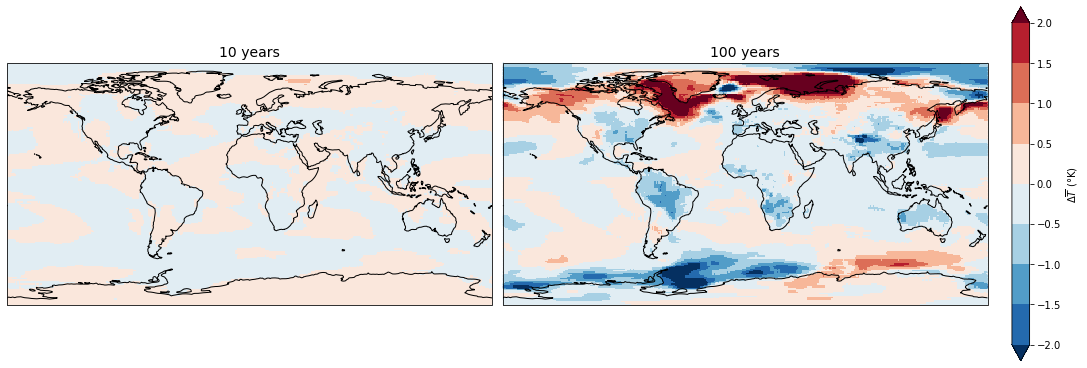

In [152]:
#hatching = ((ds_compare > minus_std) & (ds_compare < plus_std))
cbar_arg = {10:None, 100:{'label':'$\Delta \overline{T}$ ($\degree$C)'}}
cmap = mpl.cm.RdBu_r
levels = [-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0]
vmin = -2
vmax = 2
fig, (ax1, ax2)= plt.subplots(1, 2, figsize = [15,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)
##contours of convolution-1pct difference
for t, ax in zip([10,100],[ax1,ax2]):
    if ax == ax1:
        add_cbar = False
    elif ax == ax2:
        add_cbar = True
    (conv_1pct_ds -  conv_rtcre_ds).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(t-10, t+10)).mean(dim = 's').plot(ax = ax, 
                                                                                                                  cmap = cmap, levels = levels, extend = 'both', 
                                                                                                                  add_colorbar = add_cbar, cbar_kwargs= cbar_arg[t],     
                                                                                                                  transform = ccrs.PlateCarree())

    ##hatching for locations where convolution falls within 1std
   # hatching.sel(s = slice(t-10, t+10)).mean(dim = 's').plot.contourf(hatches = ['\\\\////', ''], levels = 3, colors = 'none', transform = ccrs.PlateCarree(), add_colorbar = False)
    ax.coastlines()
    ax.set_title(f'{t} years', fontsize = 14)
#plt.savefig(f'figures/paper/figure3_10_70_difference_1std.png', bbox_inches = 'tight', dpi = 300)

## Figure 3

In [25]:
ds_dif_mean = ds_dif.where(ds_dif['model'].isin(model_weights.model), drop = True).weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model')
spatial_pattern_1pct = (((ds_dif.where(ds_dif['model'].isin(model_weights.model), drop = True).sel( s = slice(70-5, 70+5)).mean(dim = 's')-ds_dif_mean.sel( s = slice(70-5, 70+5)).mean(dim = 's'))/ds_dif_mean.sel( s = slice(70-5, 70+5)).mean(dim = 's')) - 
                        ((ds_dif.where(ds_dif['model'].isin(model_weights.model), drop = True).sel( s = slice(10-5, 10+5)).mean(dim = 's')-ds_dif_mean.sel( s = slice(10-5, 10+5)).mean(dim = 's'))/ds_dif_mean.sel( s = slice(10-5, 10+5)).mean(dim = 's'))).weighted(model_weights).mean(dim = 'model')['tas']
spatial_pattern_em = (((conv_1pct_ds.sel( s = slice(70-5, 70+5)).mean(dim = 's')-conv_1pct_mean_ds.sel( s = slice(70-5, 70+5)).mean(dim = 's'))/conv_1pct_mean_ds.sel( s = slice(70-5, 70+5))).mean(dim = 's') - 
                      ((conv_1pct_ds.sel( s = slice(10-5, 10+5)).mean(dim = 's')-conv_1pct_mean_ds.sel( s = slice(10-5, 10+5)).mean(dim = 's'))/conv_1pct_mean_ds.sel( s = slice(10-5, 10+5)).mean(dim = 's'))).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type')

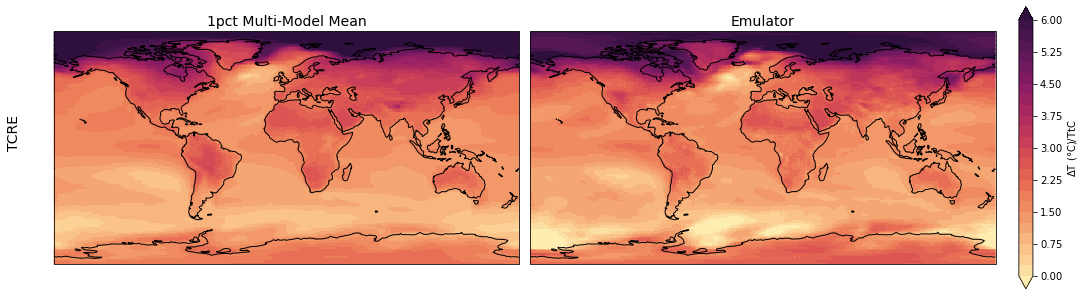

In [61]:
cmap = cmo.matter
levels = np.arange(0,6.25,0.25)
fig, ([ax1, ax3])= plt.subplots(1,2, figsize = [15,4], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)
vmin = -2
vmax = 2
#### 1pct model ###
### RTCRE
(((ds_dif.sel(s = slice(60, 80)).mean(dim = 's')/
  emis_profile.cumsum(dim = 'year')['emis'].sel(year = slice(60,80)).mean(dim = 'year')).weighted(model_weights).mean(dim = 'model'))*1e3)['tas'].plot(ax = ax1, 
                                                                  cmap = cmap, levels = levels, extend = 'both', add_colorbar = False,
                                                                transform = ccrs.PlateCarree())
ax1.coastlines()
ax1.text(x = -0.1, y = .5, s = 'TCRE', rotation = 90, fontsize = 14, transform=ax1.transAxes)
ax1.set_title('1pct Multi-Model Mean', fontsize = 14)

### Emulator ###

### RTCRE
(((conv_1pct_ds.mean(dim = 'pulse_type').sel(s = slice(60, 80)).mean(dim = 's')/
  emis_profile.cumsum(dim = 'year')['emis'].sel(year = slice(60,80)).mean(dim = 'year')).weighted(model_weights).mean(dim = 'model'))*1e3).plot(ax = ax3, 
                                                                  cmap = cmap, levels = levels, extend = 'both', 
                                                                cbar_kwargs = {'label':'$\Delta$T ($\degree$C)/TtC'}, 
                                                                transform = ccrs.PlateCarree())
ax3.coastlines()
ax3.set_title('Emulator', fontsize = 14)



plt.savefig(f'figures/paper/supp_RTCRE.png', bbox_inches = 'tight', dpi = 300)

## Spatial Minus the Global Mean

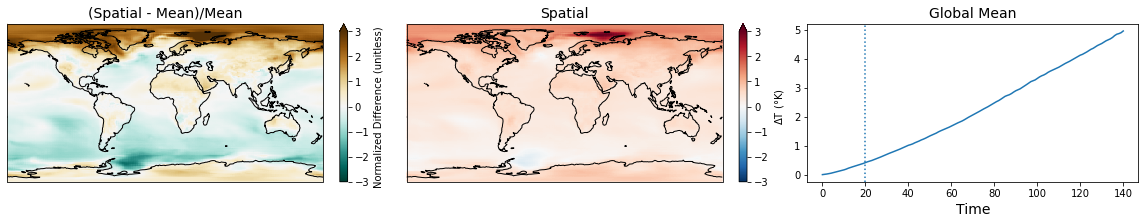

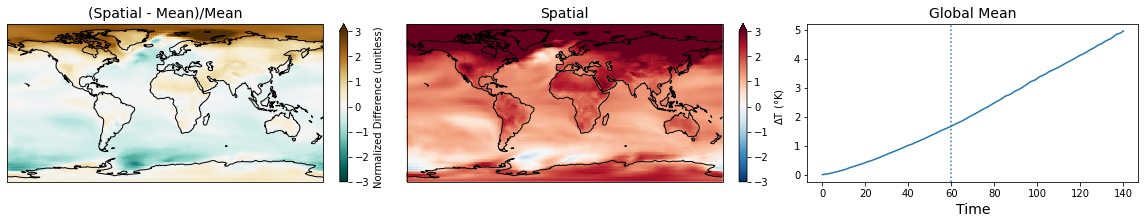

In [27]:
## plot the value at a given year for the mean
vmin = -3
vmax = 3
for t in [10,70]:
    fig = plt.figure(figsize = [16,3], constrained_layout = True)
    
    ax1 = fig.add_subplot(1,3,1, projection = ccrs.PlateCarree())
    ((conv_1pct_ds-conv_1pct_mean_ds)/conv_1pct_mean_ds).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel( s = slice(t-10, t+10)).mean(dim = 's').plot(ax = ax1, 
                                                                                                vmax = vmax, vmin = vmin, cmap = 'BrBG_r', transform = ccrs.PlateCarree(), 
                                                                                                                                               cbar_kwargs = {'label':'Normalized Difference (unitless)'})
    ax1.set_title(f'(Spatial - Mean)/Mean', fontsize = 14)
    ax1.coastlines()

    ax2 = fig.add_subplot(1,3,2, projection = ccrs.PlateCarree())
    (conv_1pct_ds).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel( s = slice(t-10, t+10)).mean(dim = 's').plot(ax = ax2, 
                                                                        vmax = vmax, vmin = vmin, cmap = 'RdBu_r',
                                                                            cbar_kwargs = {'label':'$\Delta$T ($\degree$C)'},
                                                                                transform = ccrs.PlateCarree())
    ax2.set_title('Spatial', fontsize = 14)
    ax2.coastlines()

    ax3 = fig.add_subplot(1,3,3)
    conv_1pct_mean_ds.sel(s = slice(0,140)).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax3)
    ax3.axvline(x = t, ymin = 0, ymax = 5, linestyle = ':')
    ax3.set_title('Global Mean', fontsize = 14)
    ax3.set_xlabel('Time', fontsize = 14)
    #ax3.coastlines()

    #plt.suptitle(f'Model mean at year {t}', fontsize = 16)
    plt.savefig(f'figures/1pct_increase/spatial_min_mean_{t}.png', bbox_inches = 'tight', dpi = 350)
    #plt.close();

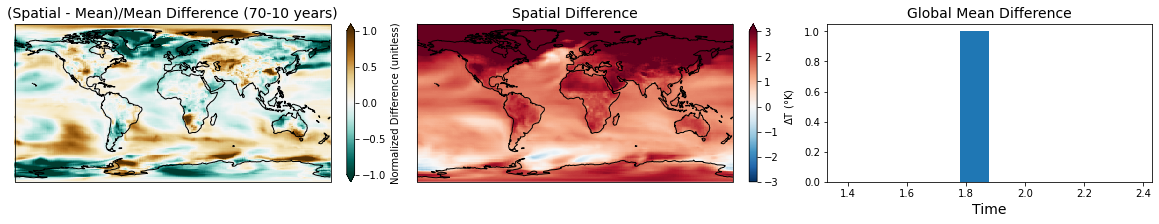

In [210]:
## plot the value at a given year for the mean difference
vmin = -3
vmax = 3
dif_yr = 10
fig = plt.figure(figsize = [16,3], constrained_layout = True)#, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5], subplot_kw = {'projection':ccrs.PlateCarree()})

ax1 = fig.add_subplot(1,3,1, projection = ccrs.PlateCarree())
(((conv_1pct_ds.sel( s = slice(70-dif_yr, 70+dif_yr)).mean(dim = 's')-conv_1pct_mean_ds.sel( s = slice(70-dif_yr, 70+dif_yr)).mean(dim = 's'))/
                    conv_1pct_mean_ds.sel( s = slice(70-dif_yr, 70+dif_yr))).mean(dim = 's') - ((conv_1pct_ds.sel( s = slice(10-dif_yr, 10+dif_yr)).mean(dim = 's')-conv_1pct_mean_ds.sel( s = slice(10-dif_yr, 10+dif_yr)).mean(dim = 's'))/conv_1pct_mean_ds.sel( s = slice(10-dif_yr, 10+dif_yr)).mean(dim = 's'))).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax1, 
                                                                                            vmax = 1, vmin = -1, cmap = 'BrBG_r', transform = ccrs.PlateCarree(), 
                                                                                                                                               cbar_kwargs = {'label':'Normalized Difference (unitless)'})
ax1.set_title(f'(Spatial - Mean)/Mean Difference (70-10 years)', fontsize = 14)
ax1.coastlines()

ax2 = fig.add_subplot(1,3,2, projection = ccrs.PlateCarree())
(conv_1pct_ds.sel( s = slice(70-dif_yr, 70+dif_yr)).mean(dim = 's') - conv_1pct_ds.sel( s = slice(10-dif_yr, 10+dif_yr)).mean(dim = 's')).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax2, 
                                                                    vmax = vmax, vmin = vmin, cmap = 'RdBu_r',
                                                                        cbar_kwargs = {'label':'$\Delta$T ($\degree$C)'},
                                                                            transform = ccrs.PlateCarree())
ax2.set_title('Spatial Difference', fontsize = 14)
ax2.coastlines()

ax3 = fig.add_subplot(1,3,3)
(conv_1pct_mean_ds.sel( s = slice(70-dif_yr, 70+dif_yr)).mean(dim = 's')-conv_1pct_mean_ds.sel( s = slice(10-dif_yr, 10+dif_yr)).mean(dim = 's')).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax3)
#ax3.axvline(x = t, ymin = 0, ymax = 5, linestyle = ':')
ax3.set_title('Global Mean Difference', fontsize = 14)
ax3.set_xlabel('Time', fontsize = 14)
#ax3.coastlines()

#plt.suptitle(f'Model mean at year {t}', fontsize = 16)
plt.savefig(f'figures/1pct_increase/spatial_min_mean_dif.png', bbox_inches = 'tight', dpi = 350)
#plt.close();

In [29]:
ds_dif_mean = ds_dif.where(ds_dif['model'].isin(model_weights.model), drop = True).weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model')

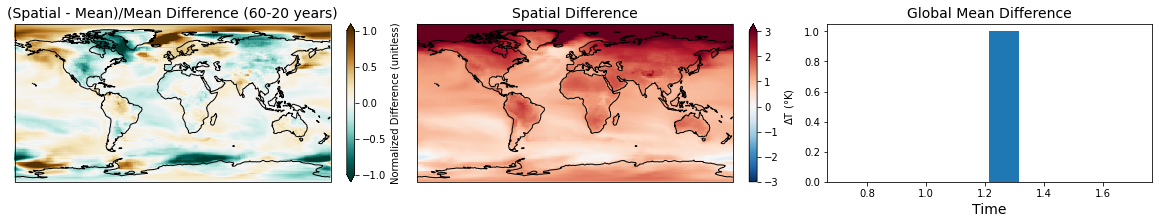

In [31]:
## plot the value at a given year for the mean difference
vmin = -3
vmax = 3
fig = plt.figure(figsize = [16,3], constrained_layout = True)#, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5], subplot_kw = {'projection':ccrs.PlateCarree()})

ax1 = fig.add_subplot(1,3,1, projection = ccrs.PlateCarree())
(((ds_dif.sel( s = slice(70-10, 70+10)).mean(dim = 's')-ds_dif_mean.sel( s = slice(70-10, 70+10)).mean(dim = 's'))/ds_dif_mean.sel( s = slice(70-10, 70+10)).mean(dim = 's')) - ((ds_dif.sel( s = slice(10-10, 10+10)).mean(dim = 's')-ds_dif_mean.sel( s = slice(10-10, 10+10)).mean(dim = 's'))/ds_dif_mean.sel( s = slice(10-10, 10+10)).mean(dim = 's'))).weighted(model_weights).mean(dim = 'model')['tas'].plot(ax = ax1, 
                                                                                            vmax = 1, vmin = -1, cmap = 'BrBG_r', transform = ccrs.PlateCarree(), 
                                                                                                                                               cbar_kwargs = {'label':'Normalized Difference (unitless)'})
ax1.set_title(f'(Spatial - Mean)/Mean Difference (70-10 years)', fontsize = 14)
ax1.coastlines()

ax2 = fig.add_subplot(1,3,2, projection = ccrs.PlateCarree())
(ds_dif.sel( s = slice(70-10, 70+10)).mean(dim = 's') - ds_dif.sel( s = slice(10-10, 10+10)).mean(dim = 's')).weighted(model_weights).mean(dim = 'model')['tas'].plot(ax = ax2, 
                                                                    vmax = vmax, vmin = vmin, cmap = 'RdBu_r',
                                                                        cbar_kwargs = {'label':'$\Delta$T ($\degree$C)'},
                                                                            transform = ccrs.PlateCarree())
ax2.set_title('Spatial Difference', fontsize = 14)
ax2.coastlines()

ax3 = fig.add_subplot(1,3,3)
(ds_dif_mean.sel( s = slice(70-10, 70+10)).mean(dim = 's')-ds_dif_mean.sel( s = slice(10-10, 10+10)).mean(dim = 's')).weighted(model_weights).mean(dim = 'model')['tas'].plot(ax = ax3)
#ax3.axvline(x = t, ymin = 0, ymax = 5, linestyle = ':')
ax3.set_title('Global Mean Difference', fontsize = 14)
ax3.set_xlabel('Time', fontsize = 14)
#ax3.coastlines()

#plt.suptitle(f'Model mean at year {t}', fontsize = 16)
plt.savefig(f'figures/1pct_increase/1pct_models_spatial_min_mean_dif.png', bbox_inches = 'tight', dpi = 350)
#plt.close();

## Recreate Lucarini Plot

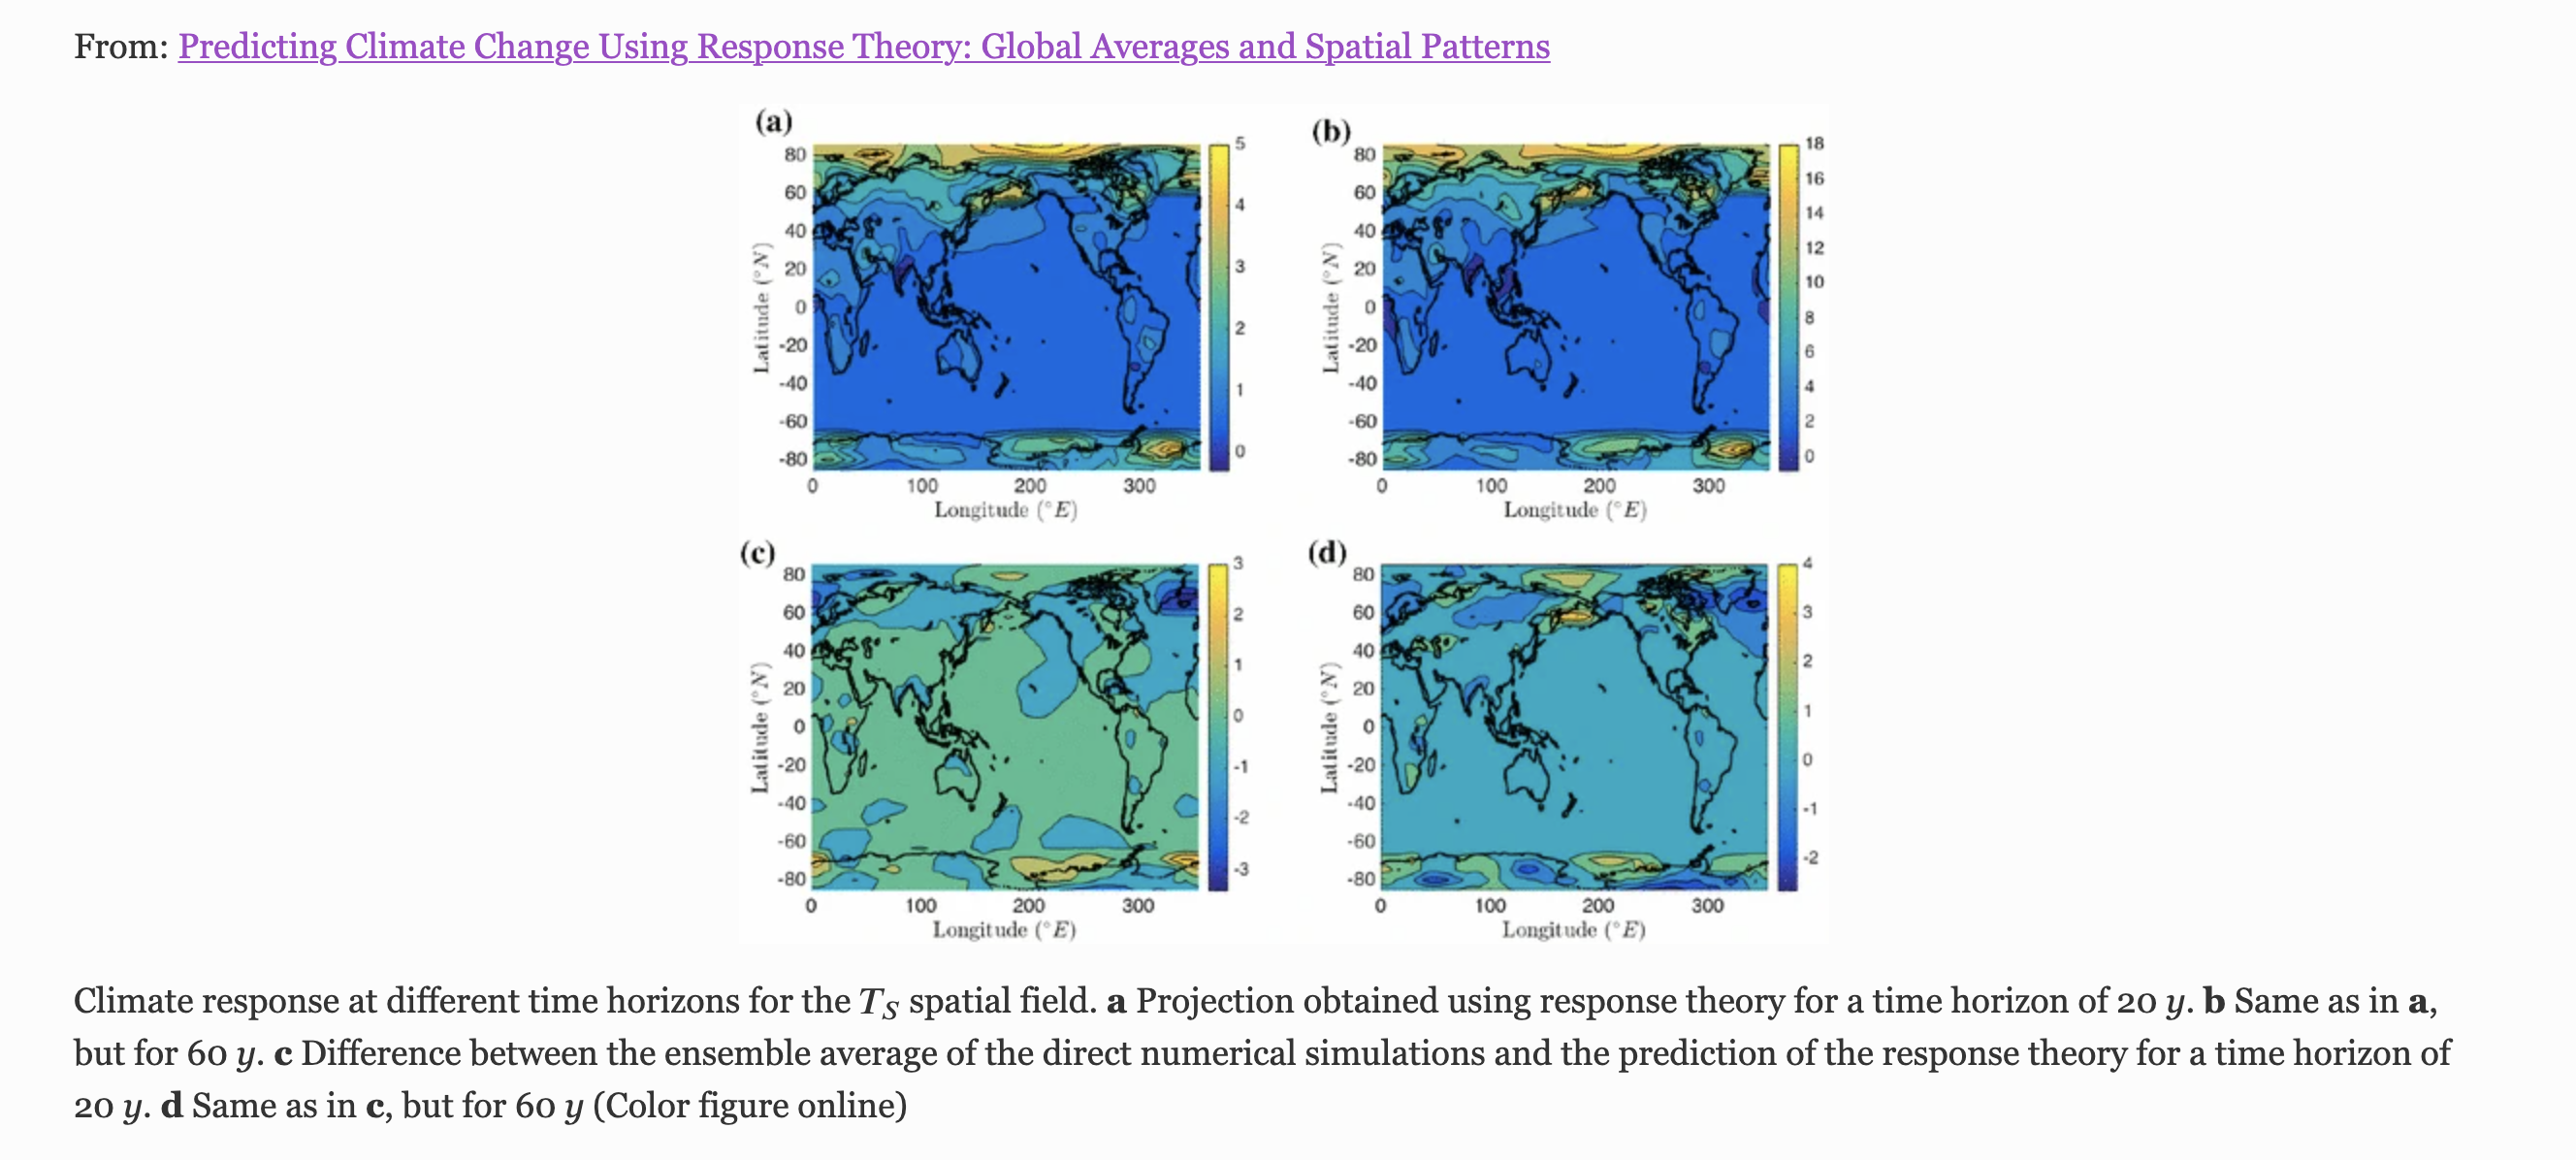

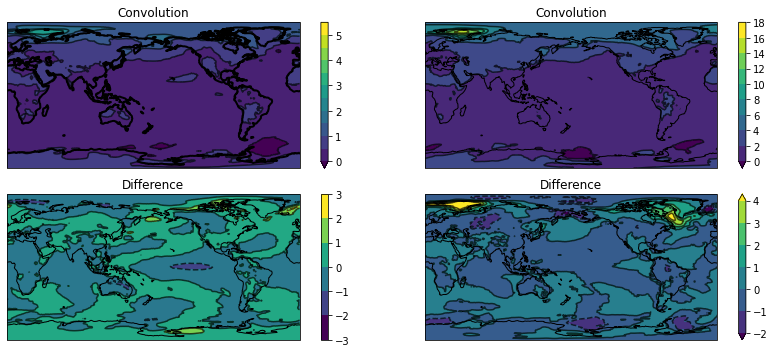

In [103]:
fig, axes = plt.subplots(2,2, figsize = [12,5], subplot_kw = {'projection':ccrs.PlateCarree(central_longitude=180)})
cmap = mpl.cm.viridis

t = 20
##twenty years convolution
ax1 = axes[0,0]

data = conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = t)
data.plot.contourf(ax = ax1, levels = np.arange(0,6,.5), cmap = cmap, transform = ccrs.PlateCarree())
data.plot.contour(ax = ax1, levels = np.arange(0,6,.5), colors = 'k', alpha = 0.7, transform = ccrs.PlateCarree())

ax1.set_title(f'Convolution')
ax1.coastlines(linewidth = 2)

##twenty years convolution-1pct
ax2 = axes[1,0]
data = (conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']) - ds_dif['tas'].weighted(model_weights).mean(dim = 'model')).sel(s = t)
data.plot.contourf(ax = ax2, levels = np.arange(-3,4,1), cmap = cmap, transform = ccrs.PlateCarree())
data.plot.contour(ax = ax2, levels = np.arange(-3,4,1), colors = 'k', alpha = 0.7, transform = ccrs.PlateCarree())

ax2.set_title('Difference')
ax2.coastlines()

t = 70
##sixty years convolution
ax3 = axes[0,1]
data = conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = t)
data.plot.contourf(ax = ax3, levels = np.arange(0,20,2), cmap = cmap, transform = ccrs.PlateCarree())
data.plot.contour(ax = ax3, levels = np.arange(0,20,2), colors = 'k', alpha = 0.7,transform = ccrs.PlateCarree())

ax3.set_title(f'Convolution')
ax3.coastlines()

##sixty years convolution-1pct
ax4 = axes[1,1]
data = (conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']) - ds_dif['tas'].weighted(model_weights).mean(dim = 'model')).sel(s = t)
data.plot.contourf(ax = ax4, levels = np.arange(-2,5,1), cmap = cmap, transform = ccrs.PlateCarree())
data.plot.contour(ax = ax4, levels = np.arange(-2,5,1), colors = 'k', alpha = 0.7, transform = ccrs.PlateCarree())

ax4.set_title('Difference')
ax4.coastlines()
plt.tight_layout()
plt.savefig(f'figures/1pct_increase/lucarini_comparison.png', bbox_inches = 'tight', dpi = 350)
#plt.close();

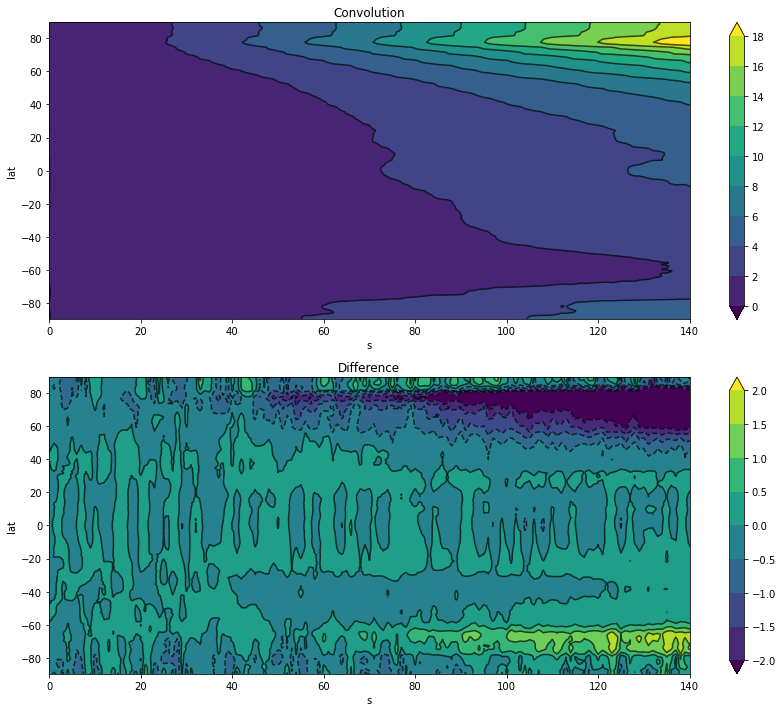

In [102]:
fig, axes = plt.subplots(2,1, figsize = [12,10])
cmap = mpl.cm.viridis

t = 20
##twenty years convolution
ax1 = axes[0]

data = conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']).mean(dim = 'lon').transpose()
data.plot.contourf(ax = ax1, levels = np.arange(0,20,2), cmap = cmap)
data.plot.contour(ax = ax1, levels = np.arange(0,20,2), colors = 'k', alpha = 0.7)
ax1.set_xlim(0,140)
ax1.set_title(f'Convolution')

#twenty years convolution-1pct
ax2 = axes[1]
data = (ds_dif['tas'].weighted(model_weights).mean(dim = 'model').weighted(A).mean(dim = 'lon')-
        conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']).mean(dim = 'lon')).transpose()
data.plot.contourf(ax = ax2, levels = np.arange(-2,2.5,.5), cmap = cmap)
data.plot.contour(ax = ax2, levels = np.arange(-2,2.5,.5), colors = 'k', alpha = 0.7)
ax2.set_xlim(0,140)
ax2.set_title('Difference')

# ax4.set_title('Difference')
# ax4.coastlines()
plt.tight_layout()
plt.savefig(f'figures/1pct_increase/lucarini_zonal_mean_comparison.png', bbox_inches = 'tight', dpi = 350)
#plt.close();